<center><h1>Visual Question Answering (VQA)</h1></center>

In [0]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

#%%capture
#!pip3 install --upgrade tensorflow-gpu
#!pip install tensorflow --upgrade

In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import time
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


<h1>Mounting the Drive </h1>

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [0]:
currentDirectory = "/content/drive/My Drive/pcase_study_2/"
os.chdir(currentDirectory)
currentDirectory = ""
dataDirectory = currentDirectory + "data/"
imageDirectory = dataDirectory + "train2014/"
imageNumpyDirectory = dataDirectory + "VGG19_Numpy/"
modelsDirectory = currentDirectory + "Models/"
img_width = 448
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [0]:
#while True:
#    try:
#        print(len(os.listdir(imageNumpyDirectory)))
#        break
#    except:
#        print("Buffer Error")
#        continue

In [0]:
data = pd.read_csv(dataDirectory + 'data.csv')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)
del data

# <h1>1. Creating Answer Vectors </h1>

In [0]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
      if i==0:
        new_text = contractions.get(word,word)
      else:
        new_text = new_text + " " + contractions.get(word,word)
      i += 1
    return new_text.replace("'s", '')

In [0]:
X_train['multiple_choice_answer'] = X_train['multiple_choice_answer'].apply(lambda x: preprocess_english(x))
X_val['multiple_choice_answer'] = X_val['multiple_choice_answer'].apply(lambda x: preprocess_english(x))

In [0]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

del all_classes

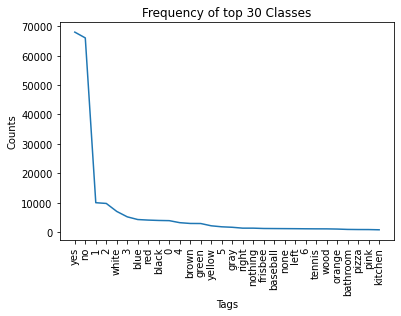

In [9]:
sort_class_frequency = sorted(list(class_frequency.items()),key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

del sort_class_frequency

5 most frequent Classes covers 45.32% points
10 most frequent Classes covers 51.46% points
20 most frequent Classes covers 57.25% points
50 most frequent Classes covers 64.02% points
70 most frequent Classes covers 66.62% points
100 most frequent Classes covers 69.50% points
200 most frequent Classes covers 75.35% points
500 most frequent Classes covers 82.89% points
750 most frequent Classes covers 85.69% points
1000 most frequent Classes covers 87.51% points
2000 most frequent Classes covers 91.27% points
3000 most frequent Classes covers 93.13% points
5000 most frequent Classes covers 95.17% points


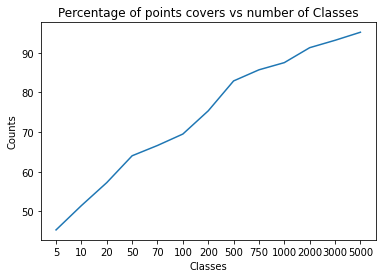

In [10]:
def getPercentageOfDataCoversGivenNumClasses(n_class, class_frequency, df):
    n_common_class = heapq.nlargest(n_class, class_frequency, key=class_frequency.get)
    count = 0
    for _class in df['multiple_choice_answer'].values:
        if(_class in n_common_class):
            count += 1

    return (count/len(df))*100
    
n_classes = [5,10,20,50,70,100,200,500,750,1000,2000,3000,5000]
percentage_cover = []
for i in n_classes:
    temp = getPercentageOfDataCoversGivenNumClasses(i,class_frequency,X_train)
    percentage_cover.append(temp)
    print("{} most frequent Classes covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of Classes")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(i,n_classes)
plt.show()

In [0]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

#removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

del class_frequency,common_tags

In [12]:
all_image_dict = {}
for i in range(1,7):
    with open(dataDirectory + 'VGG_Sample/image_dict' + str(i) + '.pickle', 'rb') as handle:
        all_image_dict_new = pickle.load(handle)
        all_image_dict.update(all_image_dict_new)
        all_image_dict_new.clear()
        print(i)
        
X_train = X_train[X_train['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).isin(all_image_dict)]
X_val = X_val[X_val['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).isin(all_image_dict)]

1
2
3
4
5
6


In [13]:
label_encoder = LabelBinarizer(sparse_output=True)
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

answer_vector_train = answer_vector_train.toarray()
answer_vector_val = answer_vector_val.toarray()

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (180587, 1000)
Shape of Answer Vectors in Validation Data:  (51479, 1000)


# <h1> 2. Creating Image Features using VGG19 </h1>

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path

def VGG_Top():
    model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape = (img_width, img_height,3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

def generateImageFeatures(images):
    model = VGG_Top()
    number_of_img_perDict = math.ceil(len(images)/10)
    count = 0
    batch_size = 16
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    for batch_img, batch_path in img_ds:
        batch_img_features = model(batch_img)

        for img_features, path in zip(batch_img_features, batch_path):
            image_path = path.numpy().decode("utf-8").replace(imageDirectory,imageNumpyDirectory).replace(".jpg","")
            np.save(image_path, img_features.numpy())
        count += batch_size
        print(count,end=',')
        if (count % (batch_size*100) ==0):
            print('')
    return

In [0]:
#all_image_path = data['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).unique()#.sort_values(["image_id"], ascending = (True))
#generateImageFeatures(all_image_path)

In [0]:
image_paths_train = X_train['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values

#with open(dataDirectory + 'all_image_dict.pickle', 'rb') as handle:
#    all_image_dict = pickle.load(handle)
#
#with open(dataDirectory + 'all_image_dict_new.pickle', 'rb') as handle:
#    all_image_dict_new = pickle.load(handle)
#
#all_image_dict.update(all_image_dict_new)
#del all_image_dict_new

# <h1>3. Creating Question Vectors </h1>

In [0]:
def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
      new_text = new_text + " " + contractions.get(word,word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [0]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_english(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_english(x))

In [19]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

del train_question_seqs,val_question_seqs
del X_train

Number of words in tokenizer: 10388
Shape of Question Vectors in Train Data:  (180587, 24)
Shape of Question Vectors in Validation Data:  (51479, 24)


# <h1>4. Creating Datasets </h1>

In [0]:
def get_imageTensor(img, ques):
    #img_tensor = np.load(img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace(".jpg","") + '.npy')
    img_tensor = all_image_dict[img.decode('utf-8')]
    #img_tensor = img_tensor.T
    img_tensor = np.reshape(img_tensor,(-1,img_tensor.shape[-1]))
    return img_tensor, ques

In [0]:
def createDataset(image_paths,question_vector,answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector))
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [0]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

# <h1>5. Coattention Model</h1>

Hierarchical Question-Image Co-Attention for Visual Question
Answering - https://arxiv.org/pdf/1606.00061v5.pdf

<img src="https://i.ibb.co/7ymC2zy/vqa-1.png" alt="vqa-1" border="0">

In addition to modeling “where to look” or visual attention, it is equally
important to model “what words to listen to” or question attention. This model has a novel co-attention model for VQA
that jointly reasons about image and question attention. The model
reasons about the question (and consequently the image via the
co-attention mechanism) in a hierarchical fashion via a novel
1-dimensional convolution neural network (CNN).

This model has a hierarchical architecture that co-attends to the image and question at three levels: (a) word level, (b) phrase level and (c) question level. At the word level, we embed the
words to a vector space through an embedding matrix. At the phrase level, 1-dimensional convolution
neural networks are used to capture the information contained in unigrams, bigrams and trigrams.Specifically, we convolve word representations with temporal filters of varying support, and then
combine the various n-gram responses by pooling them into a single phrase level representation. At
the question level, we use recurrent neural networks to encode the entire question. For each level
of the question representation in this hierarchy, we construct joint question and image co-attention
maps, which are then combined recursively to ultimately predict a distribution over the answers.

we connect the image and question by calculating the similarity between image and question features at all pairs of image-locations and question-locations


<img src="https://i.ibb.co/1rTRHWr/vqa-2.png" alt="vqa-2" border="0">

In [0]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        # atten for image feature
        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [0]:
def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

def callBacksList():
    """
    returns list of callback's
    """
    filepath = modelsDirectory + ModelName + "/best_03.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= modelsDirectory + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

def Build_CoattentionModel():
    image_input = tf.keras.layers.Input(shape = (196, 512))

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input,question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [0]:
tf.keras.backend.clear_session()
l2_alpha = 0.001
ModelName = 'Coattention'
model = Build_CoattentionModel()
model.fit(dataset_train, epochs = 30, validation_data = dataset_val, callbacks = callBacksList())

TensorBoard Folder for this Execution Models/logs/fit/Coattention/20200523-162437
Epoch 1/30
2364/2364 [==============================] - ETA: 0s - loss: 3.0379 - accuracy: 0.2820
Epoch 00001: val_accuracy improved from -inf to 0.27998, saving model to Models/Coattention/best_03.hdf5
2364/2364 [==============================] - 209s 88ms/step - loss: 3.0379 - accuracy: 0.2820 - val_loss: 2.2537 - val_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/30
2364/2364 [==============================] - ETA: 0s - loss: 2.4677 - accuracy: 0.3211
Epoch 00002: val_accuracy improved from 0.27998 to 0.30888, saving model to Models/Coattention/best_03.hdf5
2364/2364 [==============================] - 251s 106ms/step - loss: 2.4677 - accuracy: 0.3211 - val_loss: 1.9458 - val_accuracy: 0.3089 - lr: 1.0000e-04
Epoch 3/30
2364/2364 [==============================] - ETA: 0s - loss: 2.1980 - accuracy: 0.3486
Epoch 00003: val_accuracy improved from 0.30888 to 0.32839, saving model to Models/Coattention/best_03.h

In [0]:
model.load_weights(modelsDirectory + ModelName + "/best_03.hdf5")
model.evaluate(dataset_val)

805/805 [==============================] - 452s 561ms/step - loss: 1.5333 - accuracy: 0.4009


[1.5332646369934082, 0.4009401798248291]

<h2> Testing </h2>

In [0]:
all_image_dict.clear()
while True:
    try:
        print(len(os.listdir(imageDirectory)))
        break
    except:
        print("Buffer Error")
        continue

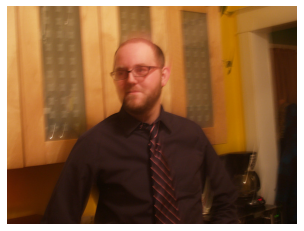

Question : what is pictured on the man tie?
Actual Answer:  stripes
Top Predicted answers:  [('stripes', 17.276169), ('nothing', 14.672234), ('man', 8.680849), ('door', 6.084312), ('words', 5.8348427)]
******************************************************************************************************************************************************


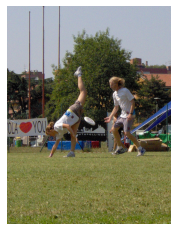

Question : what sport are the people playing?
Actual Answer:  frisbee
Top Predicted answers:  [('frisbee', 96.47128), ('tennis', 1.8999302), ('skateboarding', 0.77043545), ('soccer', 0.3551885), ('baseball', 0.26008758)]
******************************************************************************************************************************************************


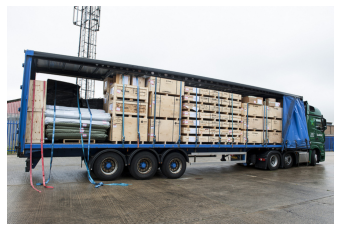

Question : what color is the truck?
Actual Answer:  blue
Top Predicted answers:  [('blue', 86.92462), ('white and blue', 5.990656), ('blue and white', 4.2067103), ('green', 2.0148196), ('white', 0.46516368)]
******************************************************************************************************************************************************


In [0]:
tf.keras.backend.clear_session()
ModelName = 'Coattention'
model = Build_CoattentionModel()
model.load_weights(modelsDirectory + ModelName + "/best_03.hdf5")
test_idx = np.random.randint(len(X_val), size = 3)
model_vgg = VGG_Top()
k = 5

for idx in test_idx:
    test_image_id = X_val['image_id'].values[idx]
    test_question = X_val['question'].values[idx]
    actual_answer = X_val['multiple_choice_answer'].values[idx]
    test_image_path = imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (test_image_id)

    test_image_features = model_vgg(tf.expand_dims(load_image(test_image_path)[0], 0))
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img=mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*150)